## Mount Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports for data pre processing

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

## Load CSVs from drive

Idimage.csv
   Contains the names of both fraud and non-fraud images.
   Includes the encoded form of these images in Base64 format.

Idmeta.csv
   Contains metadata for the non-fraud images.

Idlabel.csv
   Contains metadata for the fraud images.
   The fraud images are classified into two primary categories:
          Fraud5_inpaint_and_rewrite
          Fraud6_crop_and_replace


In [9]:
idimage = pd.read_csv('/content/drive/MyDrive/colab/598/idimage.csv')
idlabel = pd.read_csv('/content/drive/MyDrive/colab/598/idlabel.csv')
idmeta = pd.read_csv('/content/drive/MyDrive/colab/598/idmeta.csv')

print(idimage.info())
print(idlabel.info())
print(idmeta.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       998 non-null    object
 1   imageData  998 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  199 non-null    object 
 1   isfraud             199 non-null    bool   
 2   fraudpattern        199 non-null    object 
 3   srcvalue            99 non-null     object 
 4   srcfontstyle        99 non-null     object 
 5   srcfontsize         99 non-null     float64
 6   srcfontcolor        199 non-null    object 
 7   srcbbox             199 non-null    object 
 8   desvalue            99 non-null     object 
 9   desfontstyle        99 non-null     object 
 

Rows in idlabel have attributes that describe the alterations done to the original non-fraud rows present in idmeta.

So to make sure fraud examples have the attributes of idmeta (hair_color, is_veteran etc.) we have to copy over those attributes from the corresponding non-fraud rows.

The fraud ids of idlabel map to the non-fraud ids in idmeta in two ways.
1. idlabel.id == idmeta.id where idlabel.id contains "\_fake\_"
2. idlabel.desname == idmeta.id where they match directly.

The non-fraud examples are .png while fraud examples are .jpeg so we strip that information from idlabel.desname as well.  

In [13]:
# trim trailing spaces from the id attribute
idmeta["id_stripped"] = idmeta["id"].str.strip()


# get matching real id
def get_real_id(row):
    if "_fake_" in row["id"]:
        # 1: idlabel.id maps directly to idmeta.id after removing _fake_
        return row["id"].split("_fake_")[0]

    elif row["desname"] and isinstance(row["desname"], str) and row["desname"].endswith(".png"):
        # 2: match desname without .png to idmeta.id
        return row["desname"].replace(".png", "")
    return None

idlabel["real_id"] = idlabel.apply(get_real_id, axis=1)

# now merge the dataframe attributes using the matched id
idlabel_enriched = idlabel.merge(
    idmeta,
    left_on="real_id",
    right_on="id_stripped",
    how="left",
    suffixes=("", "_meta")
)
idlabel_enriched.to_csv("/content/drive/MyDrive/colab/598/idlabel_enriched.csv", index=False)
print("Saved idlabel_enriched.csv")


Saved idlabel_enriched.csv


In [21]:
idlabel_enriched.info()
idlabel_enriched.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  199 non-null    object 
 1   isfraud             199 non-null    bool   
 2   fraudpattern        199 non-null    object 
 3   srcvalue            99 non-null     object 
 4   srcfontstyle        99 non-null     object 
 5   srcfontsize         99 non-null     float64
 6   srcfontcolor        199 non-null    object 
 7   srcbbox             199 non-null    object 
 8   desvalue            99 non-null     object 
 9   desfontstyle        99 non-null     object 
 10  desfontsize         99 non-null     float64
 11  desfontcolor        199 non-null    object 
 12  desbbox             199 non-null    object 
 13  srcname             100 non-null    object 
 14  srcregionvalue      100 non-null    object 
 15  srcregionfontstyle  100 non-null    object 
 16  srcregio

,id,isfraud,fraudpattern,srcvalue,srcfontstyle,srcfontsize,srcfontcolor,srcbbox,desvalue,desfontstyle,...,issue_date,expire_date,height,weight,eye_color,hair_color,is_donor,is_veteran,license_number,id_stripped
0,generated_fake_2_66,True,Fraud6_crop_and_replace,NaN,NaN,NaN,[],[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,generated_fake_2_72,True,Fraud6_crop_and_replace,NaN,NaN,NaN,[],[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,generated.photos_v3_0011839_fake_5540,True,Fraud5_inpaint_and_rewrite,833 S. 7TH STREET,Arial_Bold.ttf,14.0,"[47, 38, 42]","[184, 199, 315, 213]",833 S. 7TH STREET,DejaVuSerif-BoldItalic.ttf,...,2021-11-30,2026-11-30,7'-01'',166 lb,BRO,BRO,False,False,D15372505,generated.photos_v3_0011839
3,generated_fake_2_99,True,Fraud6_crop_and_replace,NaN,NaN,NaN,[],[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,generated.photos_v3_0015467_fake_3788,True,Fraud5_inpaint_and_rewrite,D29721273,Arial_Bold.ttf,21.0,"[36, 36, 36]","[211, 79, 322, 100]",D29721273,DejaVuSerifCondensed-BoldItalic.ttf,...,2020-06-27,2025-06-27,5'-04'',187 lb,BRO,BRO,False,False,D29721273,generated.photos_v3_0015467


Now we have common attributes between idlabel and idmeta. In order to make our work easier we need to prepare a unified dataset with both merged into a single CSV.

We will create a new boolean attribute 'is_fraud' to identify both cases copy over and other fraud attributes as NaN to non-fraud examples. This is required to ensure we can concatenate these datasets.  


In [22]:
def prepare_unified_dataset(idlabel_enriched, idmeta):
    # get fraud dataset
    fraud_df = idlabel_enriched.copy()
    fraud_df['is_fraud'] = True

    # get non-fraud dataset
    non_fraud_df = idmeta.copy()
    non_fraud_df['is_fraud'] = False

    fraud_columns = [
        'fraudpattern', 'srcvalue', 'srcfontstyle', 'srcfontsize', 'srcfontcolor',
        'srcbbox', 'desvalue', 'desfontstyle', 'desfontsize', 'desfontcolor',
        'desbbox', 'srcname', 'srcregionvalue', 'srcregionfontstyle',
        'srcregionfontsize', 'srcregionfontcolor', 'srcregionbbox', 'srcshift',
        'desname', 'desregionvalue', 'desregionfontstyle', 'desregionfontsize',
        'desregionfontcolor', 'desregionbbox', 'desshift'
    ]

    # add missing columns to non-fraud dataset with default values
    for col in fraud_columns:
        if col not in non_fraud_df.columns:
            non_fraud_df[col] = np.nan

    # align all columns and concatenate
    common_columns = list(set(fraud_df.columns) & set(non_fraud_df.columns))
    unified_df = pd.concat([
        fraud_df[common_columns],
        non_fraud_df[common_columns]
    ], ignore_index=True)

    return unified_df

idlabel_enriched = pd.read_csv('/content/drive/MyDrive/colab/598/idlabel_enriched.csv')

unified_dataset = prepare_unified_dataset(idlabel_enriched, idmeta)
unified_dataset.to_csv('/content/drive/MyDrive/colab/598/unified_dataset.csv', index=False)

print("Saved unified_dataset.csv")
print(f"Total Rows: {len(unified_dataset)}")
print(f"Fraud Rows: {len(unified_dataset[unified_dataset['is_fraud'] == True])}")
print(f"Non-Fraud Rows: {len(unified_dataset[unified_dataset['is_fraud'] == False])}")

Saved unified_dataset.csv
Total Rows: 998
Fraud Rows: 199
Non-Fraud Rows: 799


In [23]:
unified_dataset.info()
unified_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   desshift            199 non-null    object 
 1   id                  998 non-null    object 
 2   desvalue            99 non-null     object 
 3   address             898 non-null    object 
 4   hair_color          898 non-null    object 
 5   license_number      898 non-null    object 
 6   desfontcolor        199 non-null    object 
 7   srcregionfontcolor  199 non-null    object 
 8   srcfontsize         99 non-null     float64
 9   desname             100 non-null    object 
 10  srcfontstyle        99 non-null     object 
 11  srcregionfontsize   100 non-null    float64
 12  srcregionbbox       199 non-null    object 
 13  desregionbbox       199 non-null    object 
 14  name                898 non-null    object 
 15  srcvalue            99 non-null     object 
 16  desregio

,desshift,id,desvalue,address,hair_color,license_number,desfontcolor,srcregionfontcolor,srcfontsize,desname,...,birthday,desregionfontstyle,height,issue_date,class,srcregionvalue,gender,srcname,srcshift,is_veteran
0,"[[3, 7], [8, 1]]",generated_fake_2_66,NaN,NaN,NaN,NaN,[],"[31, 27, 34]",NaN,generated.photos_v3_0347079.png,...,NaN,Arial_Bold.ttf,NaN,NaN,NaN,03/03/2023,NaN,generated.photos_v3_0686847.png,"[[8, 1], [3, 7]]",NaN
1,"[[6, 9], [8, 5]]",generated_fake_2_72,NaN,NaN,NaN,NaN,[],"[23, 42, 33]",NaN,generated.photos_v3_0471219.png,...,NaN,Arial_Bold.ttf,NaN,NaN,NaN,199 lb,NaN,generated.photos_v3_0857670.png,"[[8, 5], [6, 9]]",NaN
2,[],generated.photos_v3_0011839_fake_5540,833 S. 7TH STREET,"833 S. 7th Street, Cottonwood, AZ 86326",BRO,D15372505,"[0, 0, 0]",[],14.0,NaN,...,1997-11-19,NaN,7'-01'',2021-11-30,C,NaN,F,NaN,[],False
3,"[[8, 9], [4, 7]]",generated_fake_2_99,NaN,NaN,NaN,NaN,[],"[45, 36, 46]",NaN,generated.photos_v3_0155912.png,...,NaN,Arial_Bold.ttf,NaN,NaN,NaN,B,NaN,generated.photos_v3_0987841.png,"[[4, 7], [8, 9]]",NaN
4,[],generated.photos_v3_0015467_fake_3788,D29721273,"809 Stone Avenue, Tucson, AZ 85701",BRO,D29721273,"[0, 0, 0]",[],21.0,NaN,...,1994-12-31,NaN,5'-04'',2020-06-27,D,NaN,M,NaN,[],False


## Encode the unified dataset for training

Now that we have every attribute we can pick and choose relevant features and prepare them for model training.

In [29]:
def encode_dataset(df):

    encoded_df = df.copy()

    # init label encoders dictionary
    label_encoders = {}

    # encode categorical columns
    categorical_columns = [
        'gender', 'ethnicity', 'class', 'hair_color', 'eye_color',
        'fraudpattern', 'srcfontstyle', 'desfontstyle',
        'srcregionfontstyle', 'desregionfontstyle'
    ]

    # Encode categorical columns
    for col in categorical_columns:
        # Replace NaN with a specific string before encoding
        encoded_df[col] = encoded_df[col].fillna('Unknown')
        le = LabelEncoder()
        encoded_df[f'{col}_encoded'] = le.fit_transform(encoded_df[col])
        label_encoders[col] = le

    # encode boolean columns
    boolean_columns = ['is_donor', 'is_veteran']
    for col in boolean_columns:
        encoded_df[col] = encoded_df[col].fillna(False).astype(int)

    # parse date and convert them to datetime objects using pandas
    date_columns = ['issue_date', 'expire_date', 'birthday']
    for col in date_columns:
        encoded_df[col] = pd.to_datetime(encoded_df[col], errors='coerce')

    # calculate additional features from the dates to make encoding easier
    encoded_df['age'] = (pd.Timestamp.now() - encoded_df['birthday']).dt.days / 365.25
    encoded_df['license_validity'] = (encoded_df['expire_date'] - encoded_df['issue_date']).dt.days

    # height, weight formatted as ft'in" and x lb needs to be in plain float values. missing values are NaN
    def parse_height(height_str):
        try:
            feet, inches = height_str.replace("'", "").replace('"', '').split('-')
            return int(feet) * 12 + int(inches)
        except:
            return np.nan

    def parse_weight(weight_str):
        try:
            return float(weight_str.replace(' lb', ''))
        except:
            return np.nan

    encoded_df['height_numeric'] = encoded_df['height'].apply(parse_height)
    encoded_df['weight_numeric'] = encoded_df['weight'].apply(parse_weight)

    # select final columns for encoding
    final_columns = [
        'is_fraud', 'fraudpattern',
        'gender_encoded', 'ethnicity_encoded', 'class_encoded',
        'hair_color_encoded', 'eye_color_encoded',
        'is_donor', 'is_veteran',
        'age', 'license_validity',
        'height_numeric', 'weight_numeric'
    ]

    # handle missing values
    final_df = encoded_df[final_columns].copy()
    final_df['id'] = encoded_df['id']

    return final_df, label_encoders

unified_df = pd.read_csv('/content/drive/MyDrive/colab/598/unified_dataset.csv')

metadata_df, encoders = encode_dataset(unified_df)
metadata_df[['age', 'license_validity', 'height_numeric', 'weight_numeric']] = metadata_df[['age', 'license_validity', 'height_numeric', 'weight_numeric']].fillna(0)

# fraudpattern has 3 values to be encoded: Fraud6_crop_and_replace, Fraud5_inpaint_and_rewrite,Unknown
encoder = OrdinalEncoder()
metadata_df['fraudpattern'] = encoder.fit_transform(metadata_df[['fraudpattern']])

metadata_df.to_csv('/content/drive/MyDrive/colab/598/metadata.csv', index=False)
print("Saved metadata.csv")


Saved metadata.csv


<ipython-input-29-71b652cfcdc0>:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df[col] = encoded_df[col].fillna(False).astype(int)
<ipython-input-29-71b652cfcdc0>:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df[col] = encoded_df[col].fillna(False).astype(int)


In [26]:
# save the mapping as well for our reference later when we write queries
import json
encoder_mapping = {col: list(encoder.classes_) for col, encoder in encoders.items()}
with open('/content/drive/MyDrive/colab/598/label_encoder_mapping.json', 'w') as f:
    json.dump(encoder_mapping, f, indent=2)

In [31]:
metadata_df.info()
metadata_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_fraud            998 non-null    bool   
 1   fraudpattern        998 non-null    float64
 2   gender_encoded      998 non-null    int64  
 3   ethnicity_encoded   998 non-null    int64  
 4   class_encoded       998 non-null    int64  
 5   hair_color_encoded  998 non-null    int64  
 6   eye_color_encoded   998 non-null    int64  
 7   is_donor            998 non-null    int64  
 8   is_veteran          998 non-null    int64  
 9   age                 998 non-null    float64
 10  license_validity    998 non-null    float64
 11  height_numeric      998 non-null    float64
 12  weight_numeric      998 non-null    float64
 13  id                  998 non-null    object 
dtypes: bool(1), float64(5), int64(7), object(1)
memory usage: 102.5+ KB


,is_fraud,fraudpattern,gender_encoded,ethnicity_encoded,class_encoded,hair_color_encoded,eye_color_encoded,is_donor,is_veteran,age,license_validity,height_numeric,weight_numeric,id
0,True,1.0,2,0,4,4,4,0,0,0.000000,0.0,0.0,0.0,generated_fake_2_66
1,True,1.0,2,0,4,4,4,0,0,0.000000,0.0,0.0,0.0,generated_fake_2_72
2,True,0.0,0,1,2,2,1,0,0,27.353867,1826.0,85.0,166.0,generated.photos_v3_0011839_fake_5540
3,True,1.0,2,0,4,4,4,0,0,0.000000,0.0,0.0,0.0,generated_fake_2_99
4,True,0.0,1,1,3,2,1,0,0,30.239562,1826.0,64.0,187.0,generated.photos_v3_0015467_fake_3788


## Some Visualizatons to get an idea of our encoding

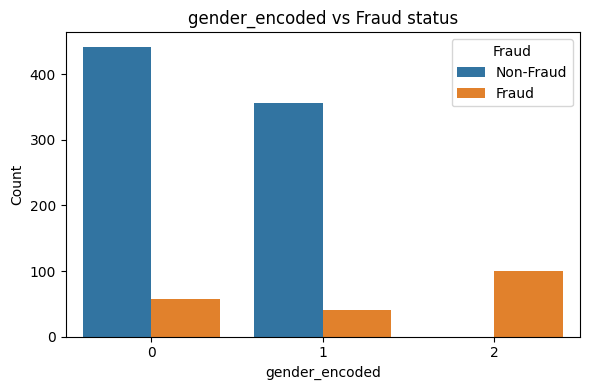

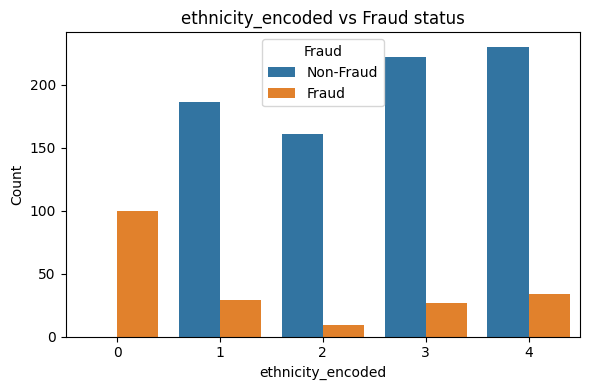

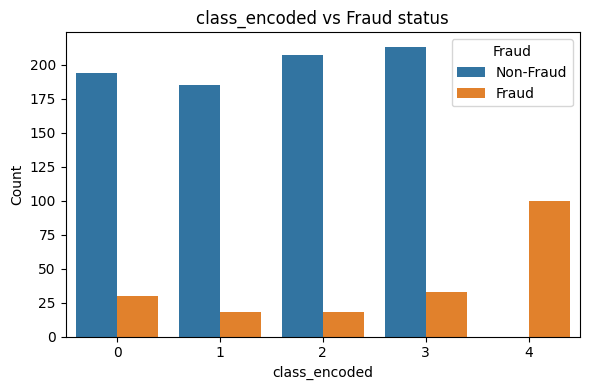

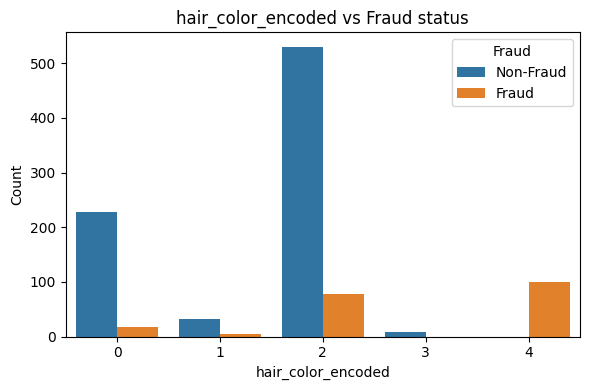

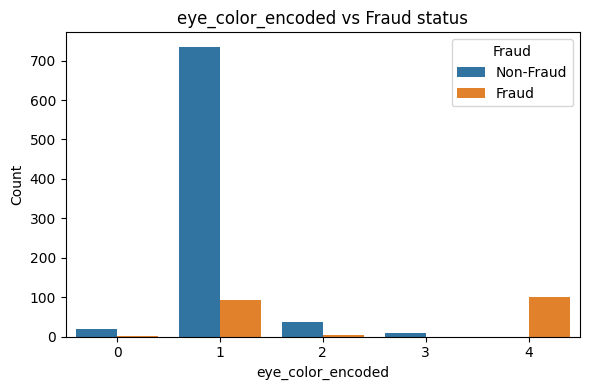

In [39]:
cat_cols = ['gender_encoded', 'ethnicity_encoded', 'class_encoded', 'hair_color_encoded', 'eye_color_encoded']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=metadata_df, x=col, hue='is_fraud')
    plt.title(f'{col} vs Fraud status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Fraud', labels=['Non-Fraud', 'Fraud'])
    plt.tight_layout()
    plt.show()


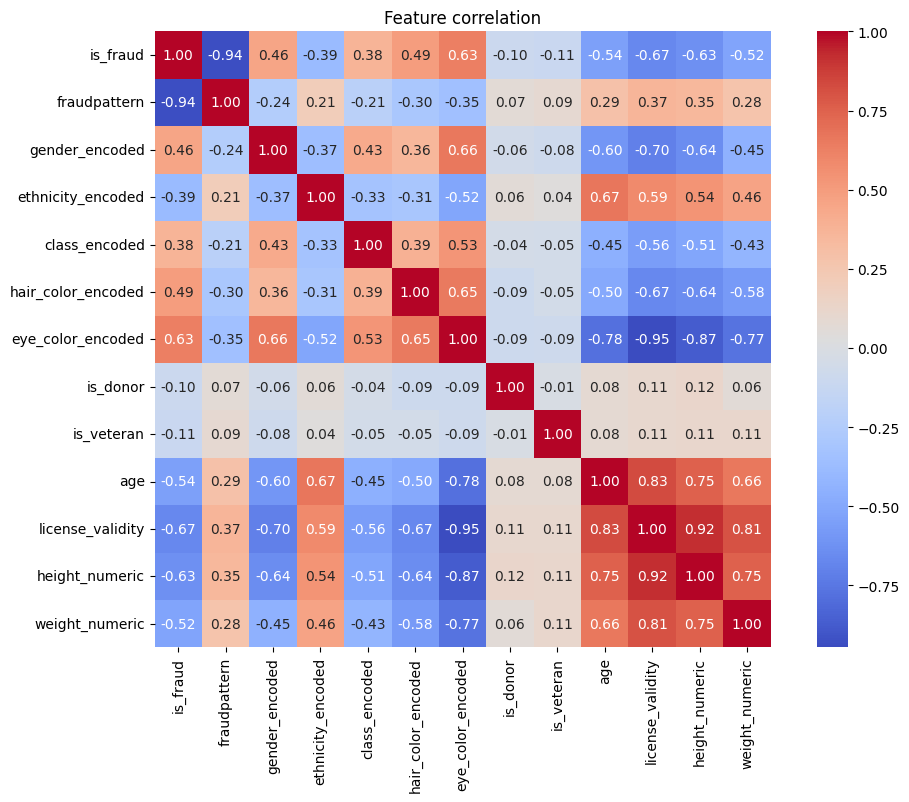

In [38]:
plt.figure(figsize=(12, 8))
corr = metadata_df.drop(columns=['id']).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature correlation')
plt.show()


Okay now we have pretty good metadata that can be incorporated with the actual imageData in base64 that we use in model training.  